In [1]:
# Essential Libraries and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Project specific Libraries
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords= set(stopwords.words("english"))  #set of english stop words
import sklearn as skl
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score
from wordcloud import wordcloud
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Data Quality Analysis

In [3]:
df= pd.read_csv('amazon_alexa.csv',sep="\t",quoting=3)

In [4]:
df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  "Sometimes while playing a game, you can answe...         1  
3  "I have had a lot of fun with this thing. My 4...         1  
4                                              Music         1

In [5]:
df.shape

(3150, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


Data Cleaning

In [7]:
df[df['verified_reviews'].isna()==True]

rating       date variation verified_reviews  feedback
473       2  29-Jun-18     White              NaN         0

In [8]:
df.dropna(inplace=True)

In [9]:
df['length']=df['verified_reviews'].apply(len)

In [10]:
df.head(8)

rating       date             variation  \
0       5  31-Jul-18      Charcoal Fabric    
1       5  31-Jul-18      Charcoal Fabric    
2       4  31-Jul-18        Walnut Finish    
3       5  31-Jul-18      Charcoal Fabric    
4       5  31-Jul-18      Charcoal Fabric    
5       5  31-Jul-18  Heather Gray Fabric    
6       3  31-Jul-18     Sandstone Fabric    
7       5  31-Jul-18      Charcoal Fabric    

                                    verified_reviews  feedback  length  
0                                      Love my Echo!         1      13  
1                                          Loved it!         1       9  
2  "Sometimes while playing a game, you can answe...         1     197  
3  "I have had a lot of fun with this thing. My 4...         1     174  
4                                              Music         1       5  
5  "I received the echo as a gift. I needed anoth...         1     174  
6  "Without having a cellphone, I cannot use many...         1     367  
7  I think this is the 5th one I've purchased. I'...         1     221

In [11]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

'Rating' Column Analysis

In [12]:
rate_count=df['rating'].value_counts()
rate_count

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

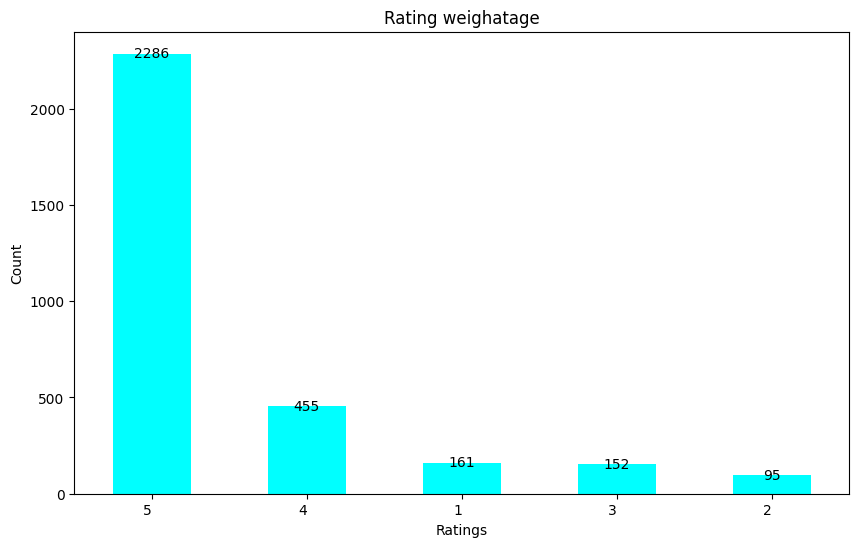

In [13]:
plt.figure(figsize=(10,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
rate_count.plot.bar(color='cyan')
plt.title('Rating weighatage')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='right')

# Adding values on top of each bar
for i, value in enumerate(rate_count):
    plt.text(i, value + 0.1, f'{value:.0f}', ha='center',va='center')
plt.show()

In [14]:
percentage=round(rate_count/df.shape[0]*100,2)
percentage

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64

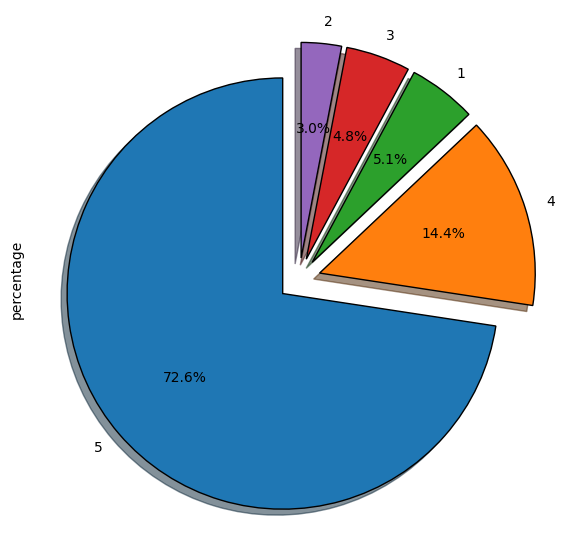

In [15]:
fig=plt.figure(figsize=(7,7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
wp={'linewidth':1,"edgecolor":'black'}
tag=rate_count/df.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tag.plot(kind='pie',autopct="%1.1f%%",shadow=True,color=colors,startangle=90,wedgeprops=wp,explode=explode,label='percentage')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph,format='png')

Feedback column analysis

In [16]:
feed_count=df['feedback'].value_counts()
feed_count

feedback
1    2893
0     256
Name: count, dtype: int64

0= negative & 1= positive

In [17]:
rev_0= df[df['feedback']==0].iloc[1]['verified_reviews']
rev_0

'Sound is terrible if u want good music too get a bose'

In [18]:
rev_1= df[df['feedback']==1].iloc[1]['verified_reviews']
rev_1

'Loved it!'

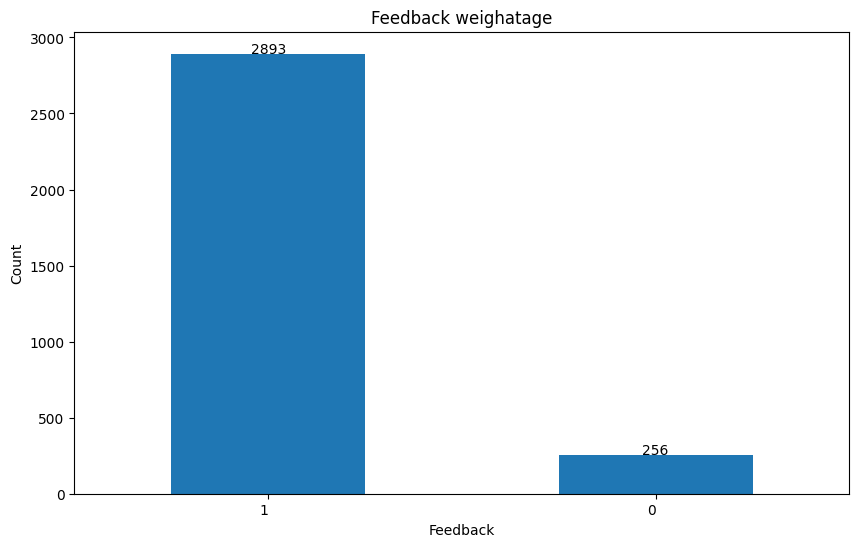

In [19]:
plt.figure(figsize=(10,6))
feed_count.plot.bar(color='#1f77b4')
plt.title('Feedback weighatage')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='right')
# Adding values on top of each bar
for i, value in enumerate(feed_count):
    plt.text(i, value + 0.1, f'{value:.0f}', ha='center')
plt.show()

In [20]:
percentage_feedback=round(feed_count/df.shape[0]*100,2)
percentage_feedback

feedback
1    91.87
0     8.13
Name: count, dtype: float64

<Axes: ylabel='percentage_feedback'>

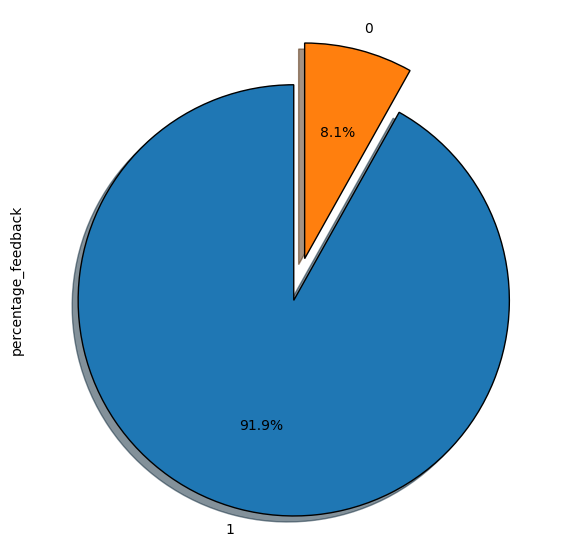

In [21]:
fig=plt.figure(figsize=(7,7))
wp={'linewidth':1,"edgecolor":'black'}
tag=feed_count/df.shape[0]
explode=(0.1,0.1)
tag.plot(kind='pie',autopct="%1.1f%%",shadow=True,color=colors,startangle=90,wedgeprops=wp,explode=explode,label='percentage_feedback')

In [22]:
feed_0_count=df[df['feedback']==0]['rating'].value_counts()
feed_0_count

rating
1    161
2     95
Name: count, dtype: int64

In [23]:
feed_1_count=df[df['feedback']==1]['rating'].value_counts()
feed_1_count

rating
5    2286
4     455
3     152
Name: count, dtype: int64

variation analysis

In [24]:
var_count=df['variation'].value_counts()
var_count

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

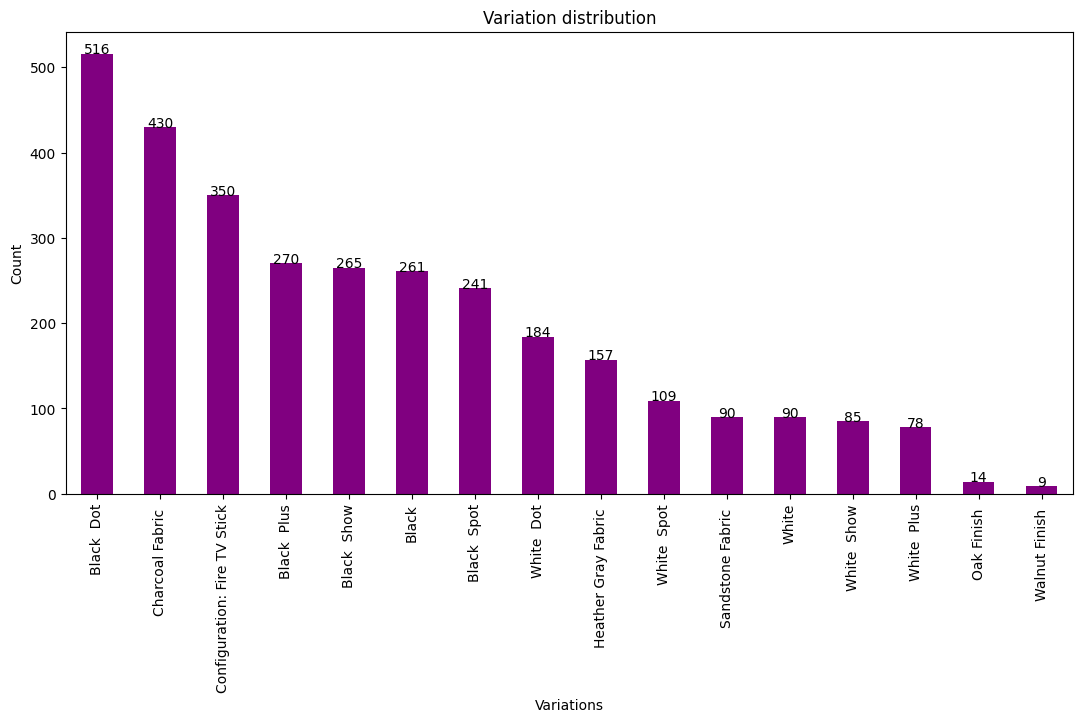

In [25]:
plt.figure(figsize=(13,6))
var_count.plot.bar(color='purple')
plt.title('Variation distribution')
plt.xlabel('Variations')
plt.ylabel('Count')
# Adding values on top of each bar
for i, value in enumerate(var_count):
    plt.text(i, value + 0.1, f'{value:.0f}', ha='center')
plt.show()

In [26]:
percentage_var=round(var_count/df.shape[0]*100,2)
percentage_var

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

In [27]:
var_mean=df.groupby('variation')['rating'].mean()
var_mean

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

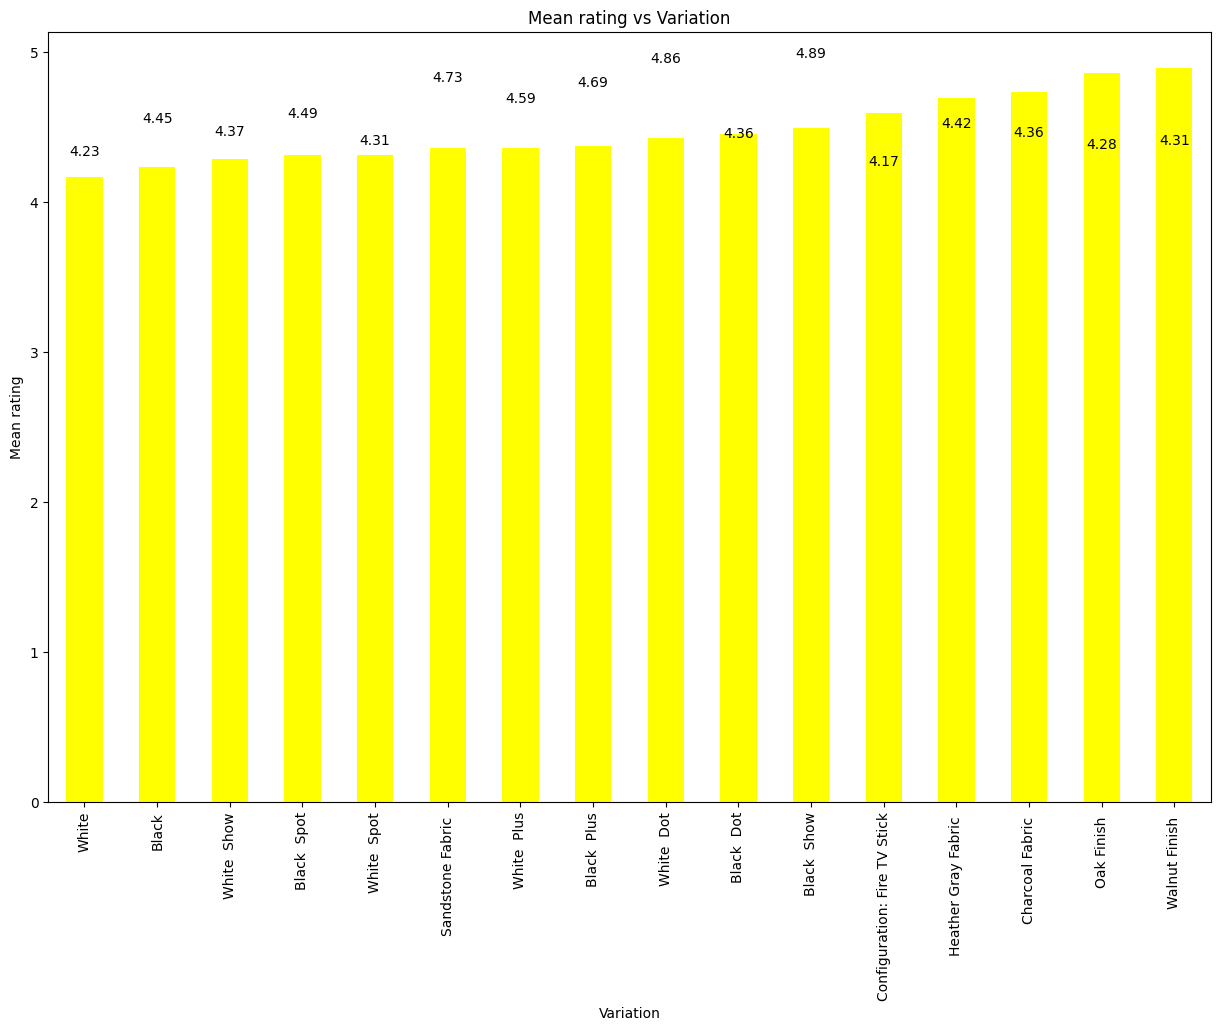

In [28]:
var_mean.sort_values().plot.bar(color ='yellow',figsize=(15,10))
plt.title("Mean rating vs Variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
# Adding values on top of each bar
for i, value in enumerate(var_mean):
    plt.text(i, value + 0.1, f'{value:.2f}', ha='center',va='center')
plt.show()

verified reviews

In [29]:
df['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of review length')]

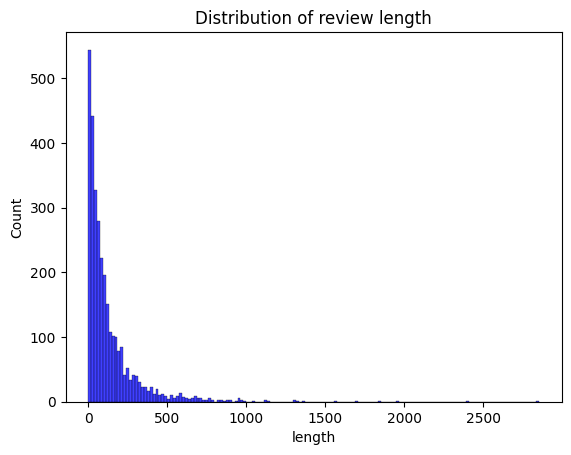

In [30]:
sns.histplot(df['length'],color='blue').set(title='Distribution of review length')

[Text(0.5, 1.0, 'Distribution of review length for Feedback = 0')]

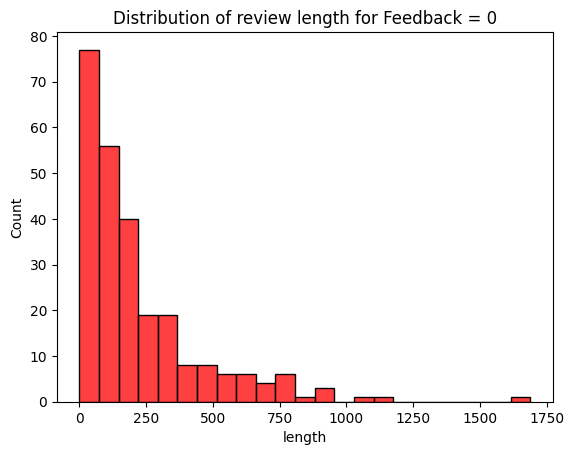

In [31]:
sns.histplot(df[df['feedback']==0]['length'],color='red').set(title='Distribution of review length for Feedback = 0')

[Text(0.5, 1.0, 'Distribution of review length for Feedback = 1')]

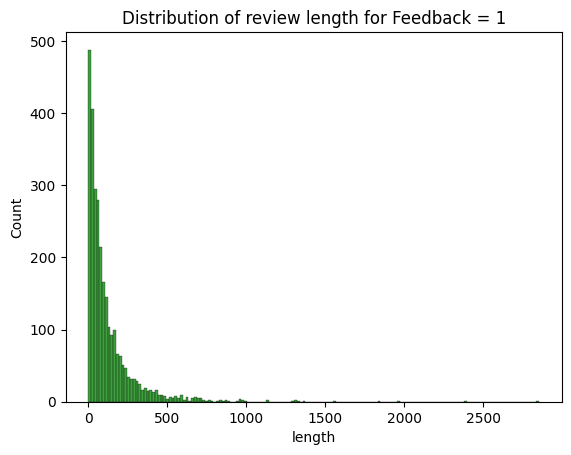

In [32]:
sns.histplot(df[df['feedback']==1]['length'],color='green').set(title='Distribution of review length for Feedback = 1')

Lengthwise mean rating

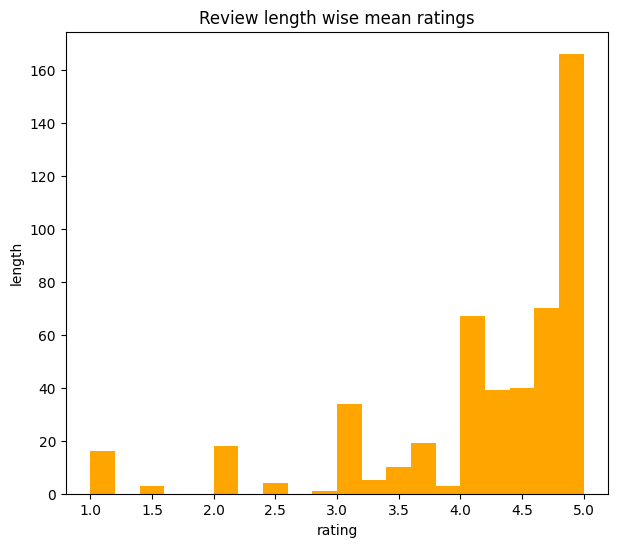

In [33]:
df.groupby('length')['rating'].mean().plot.hist(color='orange',figsize=(7,6),bins=20)
plt.title('Review length wise mean ratings')
plt.xlabel('rating')
plt.ylabel('length')
plt.show()

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

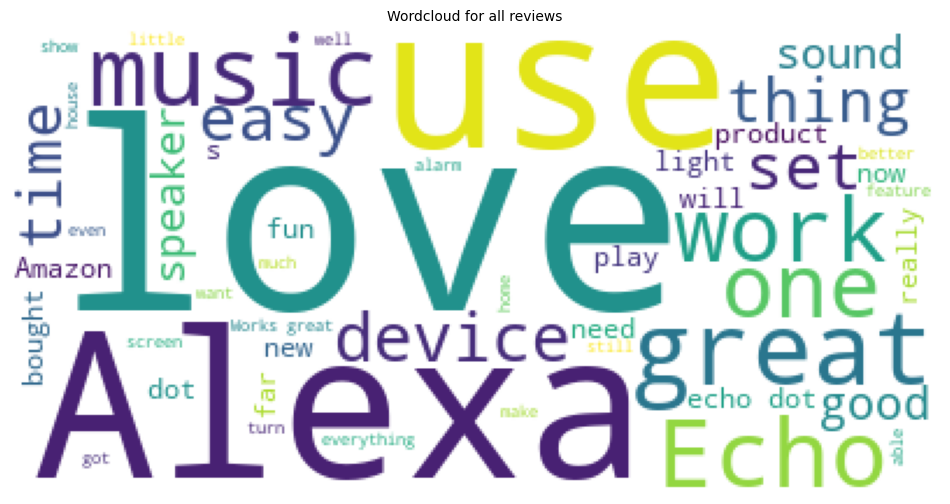

In [35]:
from wordcloud import WordCloud
#combine all reviews
reviews =' '.join([review for review in df['verified_reviews']])
#wordcloud
wc= WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(12,12))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [36]:
#Combine all reviews for each feedback categories and tokanization
neg_reviews = ' '.join([review for review in df[df['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = ' '.join([review for review in df[df['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#word finding in reviews
unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = ' '.join(unique_neg)

unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = ' '.join(unique_pos)

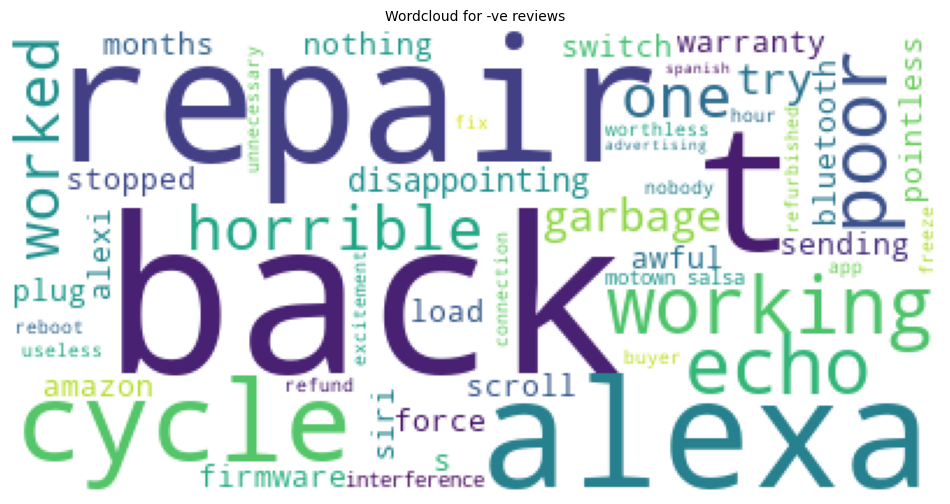

In [37]:
wc= WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(12,12))
plt.imshow(wc.generate(unique_neg))
plt.title('Wordcloud for -ve reviews', fontsize=10)
plt.axis('off')
plt.show()

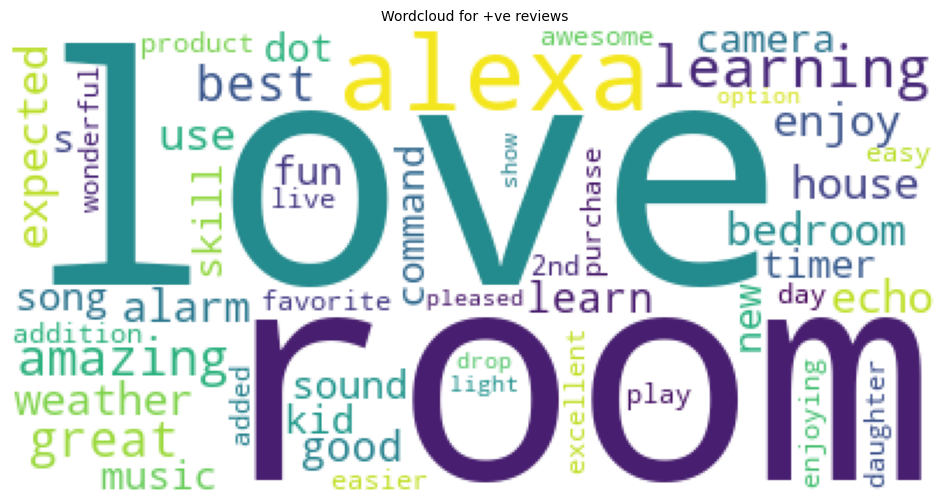

In [38]:
wc= WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(12,12))
plt.imshow(wc.generate(unique_pos))
plt.title('Wordcloud for +ve reviews', fontsize=10)
plt.axis('off')
plt.show()

Modelling

In [39]:
corpus = []
stemmer = PorterStemmer()
for i in range(0,df.shape[0]):
    review = re.sub('[^a-zA-Z]',' ',df.iloc[i]['verified_reviews']) # remove special characters, numbers
    review=review.lower().split()
    review= [stemmer.stem(word) for word in review if not word in stopwords]
    review= ' '.join(review)
    corpus.append(review)


Using Count Vectorizer to create bag of words

In [40]:
cv = CountVectorizer(max_features=2500)
#x=indepndent variable, y = dependent variable
x=cv.fit_transform(corpus).toarray()
y=df['feedback'].values

In [41]:
import os
import pickle

if not os.path.exists('Models'):
    os.makedirs('Models')

In [42]:
pickle.dump(cv,open('Models/countvectorizer.pkl','wb'))

In [43]:
x.shape, y.shape

((3149, 2500), (3149,))

30% = test, 70% = train

In [44]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=15)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2204, 2500)
(2204,)
(945, 2500)
(945,)


In [45]:
print(x_train.max())
print(x_test.max())

12
10


In [46]:
scaler = MinMaxScaler()
x_train_scl = scaler.fit_transform(x_train)
x_test_scl = scaler.transform(x_test)

In [47]:
pickle.dump(scaler,open('Models/scaler.pkl','wb'))


Random Forest

In [48]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train_scl,y_train)

RandomForestClassifier()

In [49]:
#Model Accuracy
print("Training Accuracy : ", model_rf.score(x_train_scl,y_train))
print("Testing Accuracy : ", model_rf.score(x_test_scl,y_test))

Training Accuracy :  0.9945553539019963
Testing Accuracy :  0.9407407407407408


In [50]:
#prediction on test set
y_preds=model_rf.predict(x_test_scl)

In [51]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

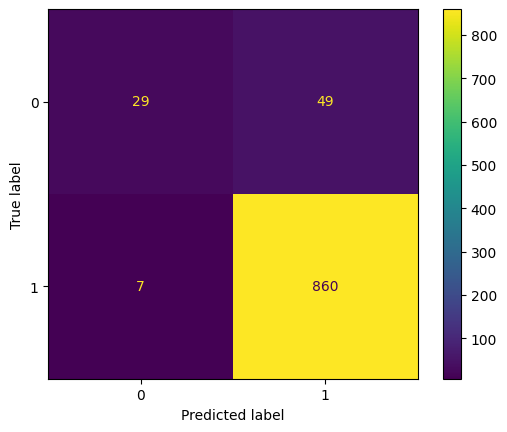

In [52]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K Fold Cross Validation

In [53]:
accuracies = cross_val_score(estimator=model_rf, X=x_train_scl, y=y_train, cv=10)
print("Accuracy:", accuracies.mean())
print('Standard Variance:',accuracies.std())


Accuracy: 0.9314911559029205
Standard Variance: 0.010429042487740663


Grid search for optimal parameters on random forset

In [54]:
params = {
    'bootstrap':[True],
    'max_depth':[80,100],
    'min_samples_split':[8,12],
    'n_estimators':[100,300]
}

In [55]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf,param_grid=params,cv=cv_object,verbose = 0, return_train_score = True)
grid_search.fit(x_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [56]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [57]:
print("Mean Accuracy on training set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Mean Accuracy on testing set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy scoreon test set:",accuracy_score(y_test,y_preds))

Mean Accuracy on training set: 96.77858439201452
Mean Accuracy on testing set: 92.17899274047187
Accuracy scoreon test set: 0.9407407407407408


XGBoost

In [58]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train_scl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
#Accuracy
print("tarining Accuracy :",model_xgb.score(x_train_scl,y_train))
print("testing Accuracy :",model_xgb.score(x_test_scl,y_test))

tarining Accuracy : 0.971415607985481
testing Accuracy : 0.9417989417989417


In [60]:
y_preds = model_xgb.predict(x_test)

In [61]:
#confusion Metrix
cm = confusion_matrix(y_test,y_preds)
cm

array([[ 31,  47],
       [ 13, 854]], dtype=int64)

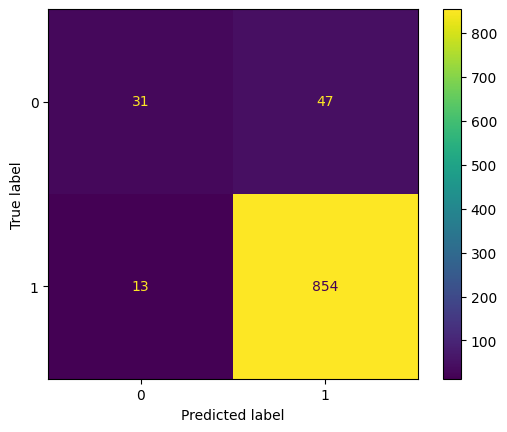

In [62]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

End